# Running big fitting experiments

In the previous notebooks, we introduced all the key ingredients for running optimisations.

In this notebook, we look at the practical side of running multiple optimisations - possibly on a big multi-core machine.
We will introduce methods to store and retrieve optimisation results, and define a method that can be used to run repeated fits.

This notebook involves a lot more programming than other notebooks.
The final functions are available from [library.py](library.py), so if you're not too bothered about how the functions work you can skip over a lot of the technical stuff!

## Storing optimisation results

Optimisation routines can be performance intensive, and to test the robustness of a particular result it's necessary to run an optimisation several times.
Some researchers may have access to fast machines for fitting that they connect to via ``ssh``, so it will be useful to store everything with _file based methods_, so that files can easily be exchanged between machines (e.g. using ``git``).

First, we'll create a method that stores the best parameters we've found in a single optimisation, along with the obtained score.
Because optimisation takes a long time, inevitably we'll get interested in performance, so just in case we'll store the number of iterations too, along with the performed number of function evaluations and the total run time\*.

(\*But please remember that benchmarking things is _hard_, so don't trust the obtained run times too much unless you've taken care to ensure no other processes etc. are running on the machine.)


In [1]:
import pints

def save(path, parameters, error, time, iterations, evaluations):
    """
    Stores a result at the given ``path``.

    Parameters
    ----------
    path
        The path to store the result at, e.g. ``output/result-123.txt``.
    parameters
        A list of paramater values.
    error
        The corresponding error (or likelihood or score).
    time
        The time taken to reach the result.
    iterations
        The number of iterations performed.
    evaluations
        The number of function evaluations performed.

    """
    error = float(error)
    time = float(time)
    iterations = int(iterations)
    evaluations = int(evaluations)

    print('Writing results to ' + str(path))
    with open(path, 'w') as f:
        f.write('error: ' + pints.strfloat(error).strip() + '\n')
        f.write('time: ' + pints.strfloat(time).strip() + '\n')
        f.write('iterations: ' + str(iterations) + '\n')
        f.write('evaluations: ' + str(evaluations) + '\n')
        f.write('parameters:\n')
        for p in parameters:
            f.write('    ' + pints.strfloat(p) + '\n')
    print('Done')

Now let's try it out!

In this tutorial, we'll use a [TemporaryDirectory](https://docs.python.org/3/library/tempfile.html#tempfile.TemporaryDirectory) so that the files we create are deleted again at the end of the example.

In [2]:
import os
import tempfile

with tempfile.TemporaryDirectory() as dirname:
    
    # Select a location to store the results
    path = os.path.join(dirname, 'results-001.txt')
    
    # Create some fake data
    parameters = [1, 2, 3, 4]
    error = 0.1
    time = 1.23
    iterations = 10
    evaluations = 20
    
    # Save!
    save(path, parameters, error, time, iterations, evaluations)
    
    # Show the contents of the file
    print('Contents of ' + path)
    print('-' * 40)
    with open(path, 'r') as f:
        print(f.read())   
    

Writing results to /tmp/tmpu8ln4uqj/results-001.txt
Done
Contents of /tmp/tmpu8ln4uqj/results-001.txt
----------------------------------------
error: 1.00000000000000006e-01
time: 1.22999999999999998e+00
iterations: 10
evaluations: 20
parameters:
     1.00000000000000000e+00
     2.00000000000000000e+00
     3.00000000000000000e+00
     4.00000000000000000e+00



Note that we've used [pints.strfloat()](https://pints.readthedocs.io/en/latest/utilities.html#pints.strfloat) to convert the floating point numbers to strings.
While the results of this method don't always look pretty, they provide enough digits to read and write a floating point `double` without loss of precision.

### A toy problem example

We'll now show the save() method used in a real optimisation.
Instead of the computationally expensive ion-channel problem we'll use a simpler toy problem from [PINTS collections of toy problems](https://pints.readthedocs.io/en/latest/toy/index.html).
A relatively easy ODE model in this set is the [logistic model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html).

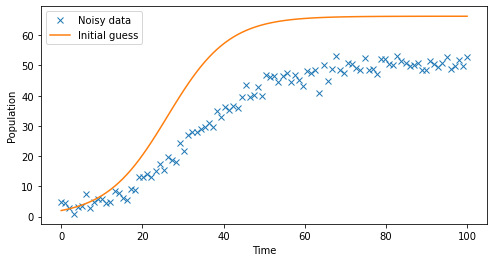

In [3]:
# Set up a toy problem
import numpy as np
import pints.toy
model = pints.toy.LogisticModel()
x_true = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(x_true, times) + np.random.normal(0, 2, times.shape)
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Select a randomised starting point
x0 = x_true * 2**np.random.normal(0, 1, x_true.shape)

# Show the simulation data
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, values, 'x', label='Noisy data')
plt.plot(times, problem.evaluate(x0), label='Initial guess')
plt.legend()
plt.show()

Writing results to /tmp/tmpsig9q6g2/results-001.txt
Done
Contents of /tmp/tmpsig9q6g2/results-001.txt
----------------------------------------
error: 3.58880848061953417e+00
time: 2.79675843000404711e-01
iterations: 290
evaluations: 1740
parameters:
     9.97976095573242655e-02
     5.04409039661833916e+01



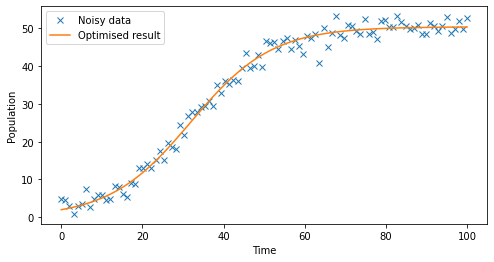

In [4]:
# Run an optimisation and store the results:
with tempfile.TemporaryDirectory() as dirname:
    
    # Select a location to store the results
    path = os.path.join(dirname, 'results-001.txt')
    
    # Create an optimisation controller
    opt = pints.OptimisationController(error, x0)
    
    # Hide optimisation output
    opt.set_log_to_screen(False)
    
    # Run the optimisation
    xopt, fopt = opt.run()
    
    # Get extra optimisation info
    time = opt.time()
    iterations = opt.iterations()
    evaluations = opt.evaluations()
    
    # Save the results   
    save(path, xopt, fopt, time, iterations, evaluations)
    
    # Show the contents of the file
    print('Contents of ' + path)
    print('-' * 40)
    with open(path, 'r') as f:
        print(f.read())   
    
# Show the resulting fit
plt.figure(figsize=(8, 4))
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, values, 'x', label='Noisy data')
plt.plot(times, problem.evaluate(xopt), label='Optimised result')
plt.legend()
plt.show()

## Loading optimisation results

We'll now set up a method that can load results from disk again.

For this, we'll assume the results files are all named e.g. `results-001.txt`, `results-002.txt`, etc.
We'll try to make the method a bit more clever, so that we don't need to manually specify these names.

We'll define a fairly "stupid" method for reading the files, but one that should be robust against minor changes to the `save()` method and allows e.g. comments to be added by users.

In [5]:
import glob

def load(template_path, n_parameters=9):
    """
    Loads and returns all results stored at a given ``template_path``.

    Parameters
    ----------
    template_path
        A template path, e.g. ``output/results.txt``, such that results can be
        found at ``output/results-001.txt``, ``output/results-002.txt``, etc.

    Returns
    -------
    A tuple ``(parameters, info)``, where ``parameters`` is a numpy array
    (with shape ``(n_entries, n_parameters)``) containing all obtained
    parameter sets, and where ``info`` is a numpy array containing one row per
    entry, and each row is structured as ``(run, error, time, iterations,
    evaluations)``. Both arrays are ordered by error (lowest error first).
    """
    # Split path into directory, base ('results'), and extension ('.txt')
    dirname, filename = os.path.split(template_path)
    basename, ext = os.path.splitext(filename)

    # Create pattern to find result files
    pattern = os.path.join(dirname, basename + '-*.txt')

    # Create empty lists
    parameters = []
    info = []

    # Find and process matching files
    for path in glob.glob(pattern):

        # Get run index from filename
        filename = os.path.split(path)[1]
        run = os.path.splitext(filename)[0]
        run = int(run.rsplit('-', 1)[1])

        # Naively parse file, warn and skip unparseable files
        error = time = iters = evals = params = None
        try:
            todo = 5
            with open(path, 'r') as f:
                for i in range(100):    # Give up after 100 lines
                    line = f.readline().strip()
                    if line.startswith('error:'):
                        error = float(line[6:])
                        todo -= 1
                    elif line.startswith('time:'):
                        time = float(line[5:])
                        todo -= 1
                    elif line.startswith('iterations:'):
                        iters = int(line[11:])
                        todo -= 1
                    elif line.startswith('evaluations:'):
                        evals = int(line[12:])
                        todo -= 1
                    elif line == 'parameters:':
                        params = [
                            float(f.readline()) for j in range(n_parameters)]
                        todo -= 1
                    if todo == 0:
                        break
                if todo:
                    print('Unable to find all information, skipping '
                          + filename)
                    continue

        except Exception as e:
            print('Error when parsing file, skipping ' + filename)
            print(e)
            continue

        # Store
        parameters.append(params)
        info.append(np.array([run, error, time, iters, evals]))

    # Convert to arrays
    parameters = np.array(parameters)
    info = np.array(info)

    # Sort by error
    if len(parameters) > 0:
        order = np.argsort(info[:, 1])
        parameters = parameters[order]
        info = info[order]

    return parameters, info

To try it out, we'll use some fake data again, and store results in a temporary directory:

In [6]:
with tempfile.TemporaryDirectory() as dirname:
    
    # Create some fake results
    for i in range(5):
    
        # Select a location to store the results
        path = os.path.join(dirname, 'results-{:03d}.txt'.format(i))

        # Create some fake data
        parameters = np.random.uniform(0, 1, 4)
        error = np.sum(parameters)
        time = np.random.normal(10, 2)
        iterations = np.random.randint(10, 30)
        evaluations = int(iterations * 2.4)

        # Save!
        save(path, parameters, error, time, iterations, evaluations)
    
    # Load the fake results
    path = os.path.join(dirname, 'results.txt')
    parameters, info = load(path, 4)

    # Display the results, from best to worse
    print()
    for i, p in enumerate(parameters):
        print('Result ranked #' + str(1 + i) + ', run ' + str(int(info[i][0])))
        print('  error: ' + str(info[i][1]))
        print('  evaluations: ' + str(int(info[i][3])))
        print('  parameters : ' + str(p))

Writing results to /tmp/tmp4tjzzz40/results-000.txt
Done
Writing results to /tmp/tmp4tjzzz40/results-001.txt
Done
Writing results to /tmp/tmp4tjzzz40/results-002.txt
Done
Writing results to /tmp/tmp4tjzzz40/results-003.txt
Done
Writing results to /tmp/tmp4tjzzz40/results-004.txt
Done

Result ranked #1, run 3
  error: 0.869624516788141
  evaluations: 20
  parameters : [0.08756749 0.46611828 0.24828545 0.06765329]
Result ranked #2, run 2
  error: 1.2797895110783075
  evaluations: 21
  parameters : [0.27561442 0.24278476 0.33140141 0.42998892]
Result ranked #3, run 1
  error: 1.5560034333027608
  evaluations: 21
  parameters : [0.00494733 0.31434043 0.65310779 0.58360788]
Result ranked #4, run 0
  error: 2.0931268328467043
  evaluations: 11
  parameters : [0.72991503 0.74048901 0.49260985 0.13011294]
Result ranked #5, run 4
  error: 2.431115028116129
  evaluations: 21
  parameters : [0.25461468 0.64197439 0.8137195  0.72080646]


Finally, we'll define a `count()` method, that simply counts how many results match the template path in a directory.
We'll do two version of this method: one that only includes full, valid results (to count the total number of finished operations), and one that counts any file (to count the total number of ongoing operations).

In [7]:
def count(template_path, n_parameters=9, parse=True):
    """
    Counts the number of results matching the given ``template_path``.

    Parameters
    ----------
    template_path
        A template path, e.g. using ``result.txt`` will count the number of
        files named ``result-x.txt`` where ``x`` can be parsed to an integer.
    n_parameters
        The expected number of parameters in each result file. This will be
        ignored if ``parse`` is ``False``.
    parse
        If set to ``True``, this method will read all files matching the
        template, and so count the number of valid, parseable files. If set to
        false any files matching the template will be counted, regardless of
        their content.
    """
    # Load and count all files
    if parse:
        parameters, info = load(template_path, n_parameters)
        return len(parameters)

    # Scan for files matching the template
    n = 0
    base, ext = os.path.splitext(template_path)
    pattern = base + '-*' + ext
    for path in glob.glob(pattern):
        # Chop off extension, and start of path
        path = os.path.splitext(path)[0]
        path = path[len(base) + 1:]

        # Attempt to parse as number
        try:
            run = int(path)
        except ValueError:
            continue
        n += 1

    return n

The following example illustrates the use of this method:

In [8]:
with tempfile.TemporaryDirectory() as dirname:
    
    # Create some fake results
    for i in range(5):
    
        # Select a location to store the results
        path = os.path.join(dirname, 'results-{:03d}.txt'.format(i))

        # Create some fake data
        parameters = np.random.uniform(0, 1, 4)
        error = np.sum(parameters)
        time = np.random.normal(10, 2)
        iterations = np.random.randint(10, 30)
        evaluations = int(iterations * 2.4)

        # Save!
        save(path, parameters, error, time, iterations, evaluations)
    
    # Add an invalid result file, e.g. an unfinished one from an optimisation
    # that's still running.
    path = os.path.join(dirname, 'results-{:03d}.txt'.format(5))
    with open(path, 'w') as f:
        f.write('This file is not valid')
    
    # Count the total number of parseable results:
    template_path = os.path.join(dirname, 'results.txt')
    n_finished = count(template_path, n_parameters=4, parse=True)
    print()
    print('Valid file count: ', n_finished)
    
    # Count the total number of files matching the template
    n_total = count(template_path, n_parameters=4, parse=False)
    print()
    print('Matching file count: ', n_total)
    n_ongoing = n_total - n_finished
    print()
    print('Optimisations running: ', n_ongoing)

Writing results to /tmp/tmpfaszacjw/results-000.txt
Done
Writing results to /tmp/tmpfaszacjw/results-001.txt
Done
Writing results to /tmp/tmpfaszacjw/results-002.txt
Done
Writing results to /tmp/tmpfaszacjw/results-003.txt
Done
Writing results to /tmp/tmpfaszacjw/results-004.txt
Done
Unable to find all information, skipping results-005.txt

Valid file count:  5

Matching file count:  6

Optimisations running:  1


## Storing output from repeated fits

Now that we have methods to store and retrieve optimisation results, an obvious next step is to run a number of fits (e.g. in a for loop), store the results, and inspect them.

But what if we have a powerful machine with many more cores than we need to run a single optimisation?
In that case, it might make sense to run our fitting script multiple times _simultaneously_.
To do this, we'll need some way for the scripts to:

- Find a free filename, e.g. "results-006.txt".
- Make it clear to other processes that this filename is now taken.

Because things can and will go wrong, we'd also like to

- Delete the results file if an exception occurs.

Below, we define a [context manager](https://docs.python.org/3/library/stdtypes.html#typecontextmanager) that can help with these tasks. 
A context manager is a Python object used in a `with` statement, e.g. in `with open(..) as f` the function `open()` returns a context manager.

In [9]:
class reserve_base_name(object):
    """
    Context manager that reserves a location for storing results, but deletes
    any partial results if an error occurs.

    A template path is specified by the user, for example
    ``output/result.txt``. Upon entering, this is converted to a numbered path,
    for example ``output/result-i.txt``, such that ``i`` equals one plus the
    highest indice already found in the same directory. To "reserve" the path,
    a file is placed at ``output/result-i.txt``, which can be overwritten by
    the user. Finally, the path to the numbered file is returned.

    If an exception occurs within the manager's context, the numbered file is
    deleted, **along with any files starting with the same basename as the
    numbered path**. For example, if the numbered path is ``result-001.txt``,
    files such as ``result-001-log.dat`` will also be deleted.

    Example::

        with reserve_base_name('output/result.txt') as basename:
            # Write to output/result-001.txt
            with open(basename + '.txt', 'w') as f:
                f.write('Writing stuff')

        with reserve_base_name('output/result.txt') as basename:
            # Write to output/result-002-log.txt
            with open(basename + '-log.txt', 'w') as f:
                f.write('Writing stuff')

    Parameters
    ----------
    template_path
        A template for the path to store results at: to store results such as
        ``results-1.txt``, ``results-2.txt`` etc., pass in the template
        ``name='results.txt'``.

    """
    def __init__(self, template_path):

        # Split path into directory, basename, and extension
        dirname, basename = os.path.split(template_path)
        self._dirname = dirname
        self._basename, self._extension = os.path.splitext(basename)

        # Indice, as integer
        self._indice = None

        # Indice formatting (must be fixed width and start with hyphen)
        self._format = '-{:03d}'
        self._nformat = 4

    def __enter__(self):

        # Find potential indice
        fs = glob.glob(os.path.join(self._dirname, self._basename + '*'))
        if fs:
            i1 = len(self._basename) + 1
            i2 = i1 + self._nformat - 1
            fs = [int(os.path.basename(f)[i1:i2]) for f in fs]
            indice = max(fs)
        else:
            indice = 0

        # Make reservation
        running = True
        while running:
            indice += 1
            path = self._basename + self._format.format(indice)
            path = os.path.join(self._dirname, path + self._extension)
            f = None
            try:
                f = open(path, 'x')     # Note: Python 3.3+ only
                f.write('Reserved\n')
                running = False
            except FileExistsError:
                # File already exists, try next indice
                pass
            finally:
                if f is not None:
                    f.close()

        # Store indice
        self._indice = indice

        # Update stored basename
        self._basename += self._format.format(indice)

        # Return numbered path
        return os.path.join(self._dirname, self._basename + self._extension)

    def __exit__(self, exc_type, exc_val, exc_tb):

        # No exception? Then exit without deleting
        if exc_type is None:
            return

        # Delete files matching pattern
        pattern = os.path.join(self._dirname, self._basename + '*')
        for path in glob.glob(pattern):
            print('Removing unfinished result file: ' + path)
            os.remove(path)

        # Don't suppress the exception
        return False

To illustrate the use of this class, we'll show a few examples.
As before, we'll do everything inside a temporary directory, so that we don't actually store the results.
Remember not to do this in real life!

In [10]:
# Create a temporary directory (only for this notebook!)
with tempfile.TemporaryDirectory() as dirname:
    
    # Get an available filename
    template_path = os.path.join(dirname, 'results.txt')
    with reserve_base_name(template_path) as path:
        
        # This should have removed the extension, and added a number
        print('Got the path: ' + path)
        
        # Store something, using the path with index
        with open(path + '.txt', 'w') as f:
            f.write('Great results!')        

Got the path: /tmp/tmpsncs76n3/results-001.txt


If we use this method repeatedly (without deleting the results in between), we'll get an free number in the filename each time:

In [11]:
# Create a temporary directory (only for this notebook!)
with tempfile.TemporaryDirectory() as dirname:
    
    # Get an available filename
    template_path = os.path.join(dirname, 'results.txt')
    with reserve_base_name(template_path) as path:
        
        # This should have removed the extension, and added a number
        print('Got the path: ' + path)
        
        # Store something, using the path with index
        with open(path + '.txt', 'w') as f:
            f.write('Great results!')            
    
    # Repeat
    with reserve_base_name(template_path) as path:
        print('Got the path: ' + path)
        with open(path + '.txt', 'w') as f:
            f.write('Great results!')        

Got the path: /tmp/tmptxwr4q04/results-001.txt
Got the path: /tmp/tmptxwr4q04/results-002.txt


If an error occurs, the results will be deleted:

In [13]:
# Create a temporary directory (only for this notebook!)
with tempfile.TemporaryDirectory() as dirname:
    template_path = os.path.join(dirname, 'results.txt')    

    with reserve_base_name(template_path) as path:
        print('Got path: ' + path)
        with open(path + '.txt', 'w') as f:
            f.write('Great results!')
            
    try:
        with reserve_base_name(template_path) as path:
            print('Got path: ' + path)
            with open(path + '.txt', 'w') as f:
                f.write('Great results!')
            with open(path + '-extra.log', 'w') as f:
                f.write('Some extra results')
            
            # Raise an error
            raise Exception
    except Exception:
        print('Oh no, an exception!')

    with reserve_base_name(template_path) as path:
        print('Got path: ' + path)
        with open(path + '.txt', 'w') as f:
            f.write('Great results!')


Got path: /tmp/tmpo6u4it31/results-001.txt
Got path: /tmp/tmpo6u4it31/results-002.txt
Removing unfinished result file: /tmp/tmpo6u4it31/results-002.txt-extra.log
Removing unfinished result file: /tmp/tmpo6u4it31/results-002.txt.txt
Removing unfinished result file: /tmp/tmpo6u4it31/results-002.txt
Oh no, an exception!
Got path: /tmp/tmpo6u4it31/results-002.txt


## Bringing it all together

We now have all the ingredients to define a `fit()` method, that will reserve a filename, run an optimisation, and store the results.

In [14]:
def fit(name, error, boundaries, transformation=None, repeats=1, cap=None):
    """
    Minimises the given ``error``, and stores the results in the directory
    ``name``.

    All files are called ``results-i.txt``, with ``i`` automatically increased
    until an available filename is found. Optimisations are run until either
    (1) the requested number of ``repeats`` is reached, or (2) until the
    specified directory contains ``cap`` results.

    Parameters
    ----------
    name
        The directory to store results in (a string).
    error
        A ``pints.ErrorMeasure`` to minimise (or a ``pints.LogLikelihood`` to
        maximise).
    boundaries
        A boundaries object, used to constrain the search and to sample initial
        starting points.
    transformation
        An optional :class:`pints.Transformation` to pass to the optimiser.
    repeats
        The maximum number of optimisations to run (default is 1).
    cap
        The maximum number of results to obtain in the given directory (default
        is ``None``, for unlimited).

    """
    debug = False

    # Create a template path
    template_path = os.path.join(name, 'result.txt')

    # Get the number of parameters
    n_parameters = error.n_parameters()

    # Check the number of repeats
    repeats = int(repeats)
    if repeats < 1:
        raise ValueError('Number of repeats must be at least 1.')

    # Check the cap on total number of runs
    if cap is not None:
        cap = int(cap)
        if cap < 1:
            raise ValueError(
                'Cap on total number of runs must be at least 1 (or None).')

    # Run
    for i in range(repeats):

        # Cap the maximum number of runs
        cap_info = ''
        if cap:
            n = count(template_path, n_parameters=n_parameters, parse=False)
            if n >= cap:
                print()
                print('Maximum number of runs reached: terminating.')
                print()
                return
            cap_info = ' (run ' + str(n + 1) + ', capped at ' + str(cap) + ')'

        # Show configuration
        print()
        print('Repeat ' + str(1 + i) + ' of ' + str(repeats) + cap_info)
        print()

        # Get base filename to store results in
        with reserve_base_name(template_path) as path:
            print('Storing results in ' + path)

            # Choose starting point
            # Allow resampling, in case error calculation fails
            print('Choosing starting point')
            x0 = f0 = float('inf')
            while not np.isfinite(f0):
                x0 = boundaries.sample(1)[0]
                f0 = error(x0)

            # Create a file path to store the optimisation log in
            log_path = os.path.splitext(path)
            log_path = log_path[0] + '-log.csv'

            # Create optimiser
            opt = pints.OptimisationController(
                error,
                x0,
                boundaries=boundaries,
                transformation=transformation,
                method=pints.CMAES)
            opt.set_log_to_file(log_path, csv=True)
            opt.set_max_iterations(3 if debug else None)
            opt.set_parallel(True)

            # Run optimisation
            print('Running')
            with np.errstate(all='ignore'): # Ignore numpy warnings
                x, f = opt.run()            # Search space

            # Store results for this run
            time = opt.time()
            iters = opt.iterations()
            evals = opt.evaluations()
            save(path, x, f, time, iters, evals)

    # Show best results
    parameters, info = load(template_path, n_parameters)
    print('Total results found: ' + str(len(parameters)))
    if len(parameters) > 0:
        print('Best score : ' + str(info[0, 1]))
        print('Worst score: ' + str(info[-1, 1]))
        print('Mean: ' + str(np.mean(info[:, 1])))
        print('Std : ' + str(np.std(info[:, 1])))

## A full example on a toy problem

We'll now apply the `fit()` method created above to our toy problem:

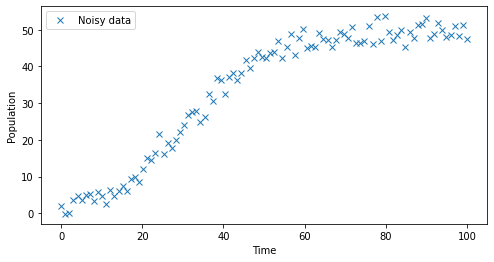

In [15]:
# Set up a toy problem
model = pints.toy.LogisticModel()
x_true = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(x_true, times) + np.random.normal(0, 2, times.shape)
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Define some boundaries
boundaries = pints.RectangularBoundaries(x_true / 10, x_true * 10)

# Define a transformation
transformation = pints.ComposedTransformation(
    pints.IdentityTransformation(n_parameters=1),
    pints.ScalingTransformation([1 / 500]))

# Show the simulation data
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, values, 'x', label='Noisy data')
plt.legend()
plt.show()

Now, we'll run 3 optimisations, and then inspect the results

In [16]:
# Run an optimisation and store the results:
with tempfile.TemporaryDirectory() as dirname:
    fit(dirname, error, boundaries, transformation, repeats=3)
    
    # Show contents of temporary directory
    print()
    print('Generated files:')
    for f in os.listdir(dirname):
        print('  ' + f)


Repeat 1 of 3

Storing results in /tmp/tmp_uc18syj/result-001.txt
Choosing starting point
Running
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 6 worker processes.
Population size: 6
Iter. Eval. Best      Time m:s
0     1      481.4519   0:00.0
1     5      170.0954   0:00.0
2     10     170.0954   0:00.1
3     13     87.21595   0:00.1
20    115    4.226758   0:00.2
40    235    3.87827    0:00.3
60    355    3.877786   0:00.3
80    475    3.877786   0:00.4
100   595    3.877786   0:00.4
120   715    3.877786   0:00.5
140   835    3.877786   0:00.5
160   955    3.877786   0:00.6
180   1075   3.877786   0:00.6
200   1195   3.877786   0:00.7
220   1315   3.877786   0:00.7
240   1435   3.877786   0:00.8
260   1555   3.877786   0:00.8
277   1651   3.877786   0:00.8
Halting: No significant change for 200 iterations.
Writing results to /tmp/tmp_uc18syj/result-001.txt
Done

Repeat 2 of 3

Storing results in /tmp/tmp_uc18syj/r

As we can see, each optisation has created a results file (`result-xxx.txt`), which can be readily parsed by `load()`.

In addition, we've stored the optimistation log (the scores over time etc., as get printed to the screen) in a CSV file, so that we can inspect results offline.

Finally, we show the use of the `cap` argument.
This caps the total number of optimisations run, and can override the `repeats` argument:

In [17]:
# Run an optimisation and store the results:
with tempfile.TemporaryDirectory() as dirname:
    fit(dirname, error, boundaries, transformation, repeats=3, cap=4)
    fit(dirname, error, boundaries, transformation, repeats=3, cap=4)


Repeat 1 of 3 (run 1, capped at 4)

Storing results in /tmp/tmp4y5u75bx/result-001.txt
Choosing starting point
Running
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 6 worker processes.
Population size: 6
Iter. Eval. Best      Time m:s
0     4      85105.4    0:00.0
1     10     21659.52   0:00.1
2     15     476.4324   0:00.1
3     21     48.03281   0:00.1
20    105    12.11629   0:00.2
40    225    3.877802   0:00.3
60    345    3.877786   0:00.3
80    465    3.877786   0:00.3
100   585    3.877786   0:00.4
120   705    3.877786   0:00.4
140   825    3.877786   0:00.5
160   945    3.877786   0:00.5
180   1065   3.877786   0:00.6
200   1185   3.877786   0:00.6
220   1305   3.877786   0:00.7
240   1425   3.877786   0:00.7
260   1545   3.877786   0:00.7
280   1665   3.877786   0:00.8
288   1707   3.877786   0:00.8
Halting: No significant change for 200 iterations.
Writing results to /tmp/tmp4y5u75bx/result-001.txt
Done



The "cap" argument can be very useful to restart a set of fits after unexpected termination, or when running multiple fits simultaneously (see below).

## A  note on parallelisation

In the above example, we've accounted for two types of parallelisation:

- Using [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) in a single optimisation to perform function evaluation in parallel.
- Running multiple optimisations at once, e.g. by running optimisations from multiple terminals, or using [tmux](https://github.com/tmux/tmux/wiki).

The multiprocessing was handled by the [pints.OptimisationController](https://pints.readthedocs.io/en/latest/optimisers/running.html#pints.OptimisationController).
On linux and linux-based OS/X, this is fairly straightforward and should work out of the box.
On windows, there can be a few extra difficulties.
Most notably:

- You'll need to ensure the main part of your script starts with `if __name__ == '__main__':`. This stops Windows from re-running the set-up code in every subprocess
- You may require Myokit version 1.31.0 or higher


## Summary

In this part of the tutorial, we

- Set up methods to store and retrieve optimisation results using the file system
- Created a method to run repeated fits
- Briefly discussed parallelisation

Some of the classes we've created here may be useful for general-purpose fitting, so we've stored them in the file [library.py](library.py).

In the next part of the tutorial we will take a look at methods to test the quality of the obtained fits.